In [1]:
import sys
sys.path.append('../scripts')
from track_instruments import track_instruments

import os
import torch
from torchvision.transforms.functional import resize as resize_tensor
import cv2
import numpy as np
from base64 import b64encode
from cotracker.utils.visualizer import Visualizer, read_video_from_path
from IPython.display import HTML
from transformers import pipeline
from PIL import Image

2025-08-26 02:56:37.345563: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 02:56:37.377487: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-26 02:56:38.064825: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Using a slow image processor as `use_fast` is unset and a slow proce

In [2]:
video_path = '/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/data/tmp/temp_video.mp4'
video = read_video_from_path(video_path)
video = torch.from_numpy(video).permute(0, 3, 1, 2).float()

In [3]:
def show_video(video_path):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width="640" height="480" autoplay loop controls><source src="{video_url}"></video>""")
show_video(video_path)

In [4]:
from cotracker.predictor import CoTrackerPredictor

cotracker_checkpoint_path = '/home/firdavs/surgery/surgical_fb_generation/SurgFBGen/checkpoints/cotracker3.pth'
cotracker_model = CoTrackerPredictor(checkpoint=cotracker_checkpoint_path)

tracks, depths, masks = track_instruments(video_path, cotracker_model)

Loaded video from temp_video.mp4 with shape torch.Size([52, 3, 250, 320])


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [5]:
tracks.shape

torch.Size([1, 52, 30, 2])

--- Cropped Images ---


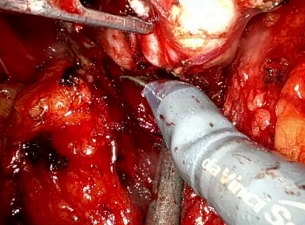

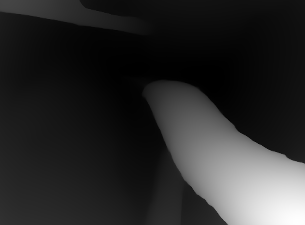

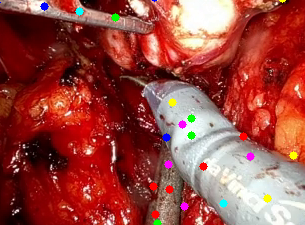

In [16]:
from PIL import Image
import matplotlib.pyplot as plt

def plot_dots_on_frame(video_tensor, tracks_tensor, frame_idx):
    frame_to_display = video_tensor[frame_idx].cpu().numpy().astype(np.uint8).transpose(1, 2, 0)

    dots_coords = tracks_tensor[frame_idx].cpu().numpy()
    x_coords = dots_coords[:, 0]
    y_coords = dots_coords[:, 1]

    fig, ax = plt.subplots(1, figsize=(10, 10))
    
    ax.imshow(frame_to_display)
    
    for i in range(len(x_coords)):
        ax.scatter(x_coords[i], y_coords[i], s=200 ,cmap='viridis', edgecolors='white', linewidth=1, color='C'+str(i))
    
    ax.set_title(f'Frame {frame_idx} with Tracked Dots', fontsize=16)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def overlay_dots_on_image(video_tensor, tracks_tensor, frame_idx, dot_radius=5):
    frame = video_tensor[frame_idx].cpu().numpy().astype(np.uint8).transpose(1, 2, 0)
    output_image = frame.copy()

    height, width, _ = output_image.shape

    dots_coords = tracks_tensor[frame_idx].cpu().numpy()

    colors_bgr = [
        (0, 0, 255),
        (0, 255, 0),
        (255, 0, 0),
        (0, 255, 255),
        (255, 0, 255),
        (255, 255, 0),
    ]

    for i, (x, y) in enumerate(dots_coords):
        if x >= 0 and y >= 0 and x < width and y < height:
            color = colors_bgr[i % len(colors_bgr)]
            center_coordinates = (int(x), int(y))
            cv2.circle(output_image, center_coordinates, dot_radius, color, thickness=-1)

    return output_image

# plot_dots_on_frame(video, tracks[0], frame_idx)

# 0, 40, 48
frame_idx = 48

image = video[frame_idx].cpu().numpy().astype(np.uint8).transpose(1, 2, 0)
depth_image = depths[frame_idx].cpu().numpy().astype(np.uint8)
image_with_dots = overlay_dots_on_image(video, tracks[0], frame_idx, dot_radius=4)

# display(Image.fromarray(image))
# display(Image.fromarray(depth_image))
# display(Image.fromarray(image_with_dots))

top_crop = 10
bottom_crop = 15
left_crop = 5
right_crop = 10

height, width, _ = image.shape
start_row = top_crop
end_row = height - bottom_crop
start_col = left_crop
end_col = width - right_crop
cropped_image = image[start_row:end_row, start_col:end_col]
cropped_depth = depth_image[start_row:end_row, start_col:end_col]
cropped_image_with_dots = image_with_dots[start_row:end_row, start_col:end_col]

print("--- Cropped Images ---")
display(Image.fromarray(cropped_image))
display(Image.fromarray(cropped_depth))
display(Image.fromarray(cropped_image_with_dots))


/tmp/ipykernel_559176/3398011357.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x_coords[i], y_coords[i], s=200,cmap='viridis', edgecolors='white', linewidth=1, color='C'+str(i))


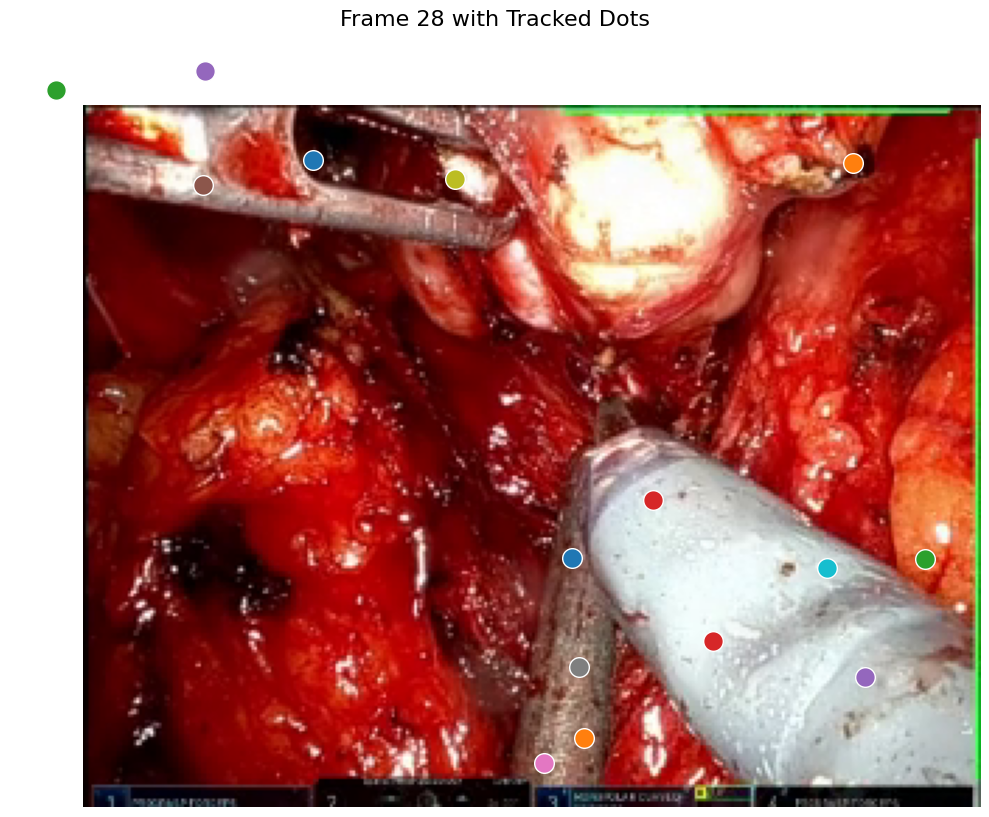

In [ ]:
import matplotlib.pyplot as plt

def plot_dots_on_frame(video_tensor, tracks_tensor, frame_idx):
    frame_to_display = video_tensor[frame_idx].cpu().numpy().astype(np.uint8).transpose(1, 2, 0)

    dots_coords = tracks_tensor[frame_idx].cpu().numpy()
    x_coords = dots_coords[:, 0]
    y_coords = dots_coords[:, 1]

    fig, ax = plt.subplots(1, figsize=(10, 10))
    
    ax.imshow(frame_to_display)
    
    for i in range(len(x_coords)):
        ax.scatter(x_coords[i], y_coords[i], s=200 ,cmap='viridis', edgecolors='white', linewidth=1, color='C'+str(i))
    
    ax.set_title(f'Frame {frame_idx} with Tracked Dots', fontsize=16)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_dots_on_frame(video, tracks[0], frame_idx)

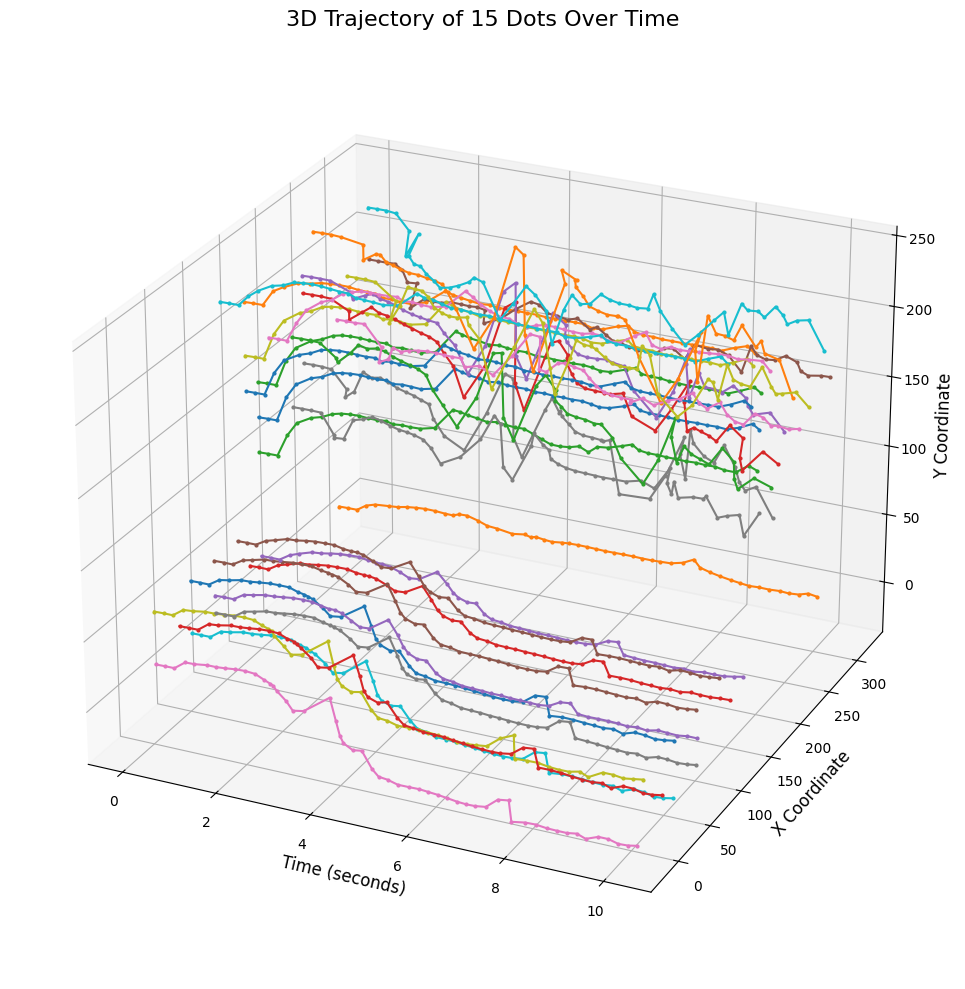

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def plot_3d_dot_trajectories(tracks_tensor):
    num_frames, num_dots, _ = tracks_tensor.shape
    
    fps = 5.0
    time_in_seconds = np.arange(num_frames) / fps

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(num_dots):
        x_coords = tracks_tensor[:, i, 0]
        y_coords = tracks_tensor[:, i, 1]
        # The order of arguments determines which data goes on which axis.
        # ax.plot(x, y, z, ...)
        ax.plot(time_in_seconds, x_coords, y_coords, marker='o', markersize=2, linestyle='-', label=f'Dot {i+1}', color='C'+str(i))

    ax.set_title('3D Trajectory of 15 Dots Over Time', fontsize=16)
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('X Coordinate', fontsize=12)
    ax.set_zlabel('Y Coordinate', fontsize=12)
    ax.grid(True)
    ax.view_init(elev=25, azim=-65)

    plt.tight_layout()
    plt.show()
    
plot_3d_dot_trajectories(tracks.cpu().numpy()[0])